In [1]:
using LinearAlgebra, Distributions, BenchmarkTools

function randmatrix(n::Int64, m::Int64)
    p = Float64(m)/Float64(n)^2 #Calculates success rate
    M = rand(Bernoulli(p), n, n) #Creates n×n bernoulli matrix (0 and 1s)
    N = rand(Uniform(-1,1), n, n) #Creates n×n matrix with values random between -1 and 1
    for i = 1:n
        for j = 1:n
            if M[i,j] == 0
                N[i,j] = 0.0 #If value in M is 0, corresponding value in N is changed to 0.0, otherwise, do nothing
            end
        end
    end
    return N
end
"""
Given a real square matrix M and an integer m, outputs householder reflection of for the mth column
"""
function house(M::Matrix, m::Int64, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:m
        A = A[1:n-i+1 .!= 1,: ] #Removes first m rows
    end
    a = A[:,m] #Extracts mth column (with only n-m elements now)
    e = I[1:(n-m), 1] #Creates vector with n-m elements, leading with 1 and all other elements 0
    w = a - norm(a)*e #Calculates w
    if norm(w) > ϵ
        P = Float64.(Matrix(I, n-m, n-m)) - (2w*(w'))/(norm(w)^2) #Calculates householder matrix P
    else
        P = Float64.(Matrix(I, n-m, n-m))
    end
    U = Float64.(Matrix(I, n, n)) #Initialises identity matrix
    for i = 1:n-m
        for j = 1:n-m
            U[i+m,j+m] = P[i,j] #Extends P to n×n dimensions by inserting P into the bottom right corner of an identity matrix
        end
    end
    return U #Returns householder transformation U
end

"""
Calculates similar hessenberg matrix of a given real square matrix M
"""
function hessen(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:n-2
        U = house(A, i, n, ϵ) #Recursively generates householder transformation
        A = U*A*(U') #Applies transformation to A (uses conjugate transpose to retain similarity)
    end
    return A #Returns hessenberg matrix A
end 


"""
Computes Givens Rotation that shifts 2×2 matrix with left column [a b] in to an upper-triangular matrix (bottom left 0)
"""
function given(a::ComplexF64, b::ComplexF64, ϵ::Float64) #ϵ is the error
    u = (abs2(a) + abs2(b))^0.5 #Calculates norm of vector [a b]
    if u > ϵ
        c = a/u #Calculates c
        s = b/u #Calculates s
        G = [conj(c) conj(s); -s c] #Calculates Givens Rotation G
        return G #Returns G
    else
        return [1 0; 0 1]
    end
end


"""
Calculates QR form of a real square matrix using Hessenberg reduction and Givens Rotations
"""
function hessenqrdecomp(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M)
    T = Matrix(I, n, n) #Initialises product of Givens Rotations
    for i = 1:n-1 #As Givens rotations are 2×2 matrixs, we only need to do n-1, not n, iterations
        a = A[i,i] #Extract arguements for given() function
        b = A[i+1,i]
        G = given(a, b, ϵ) #Creates Givens Rotation
        F = ComplexF64.(Matrix(I, n, n)) #Initialises n×n identity matrix
        F[i,i], F[i,i+1], F[i+1,i], F[i+1,i+1] = G[1,1], G[1,2], G[2,1], G[2,2] #Inserts Givens Rotation along the diagonal
        T = F*T #Updates product of Givens Rotations
        A = F*A #Applies Givens Rotation to A
    end
    R = A #Calculates R
    Q = T' #Calculates Q 
    return Q, R #Return QR form
end


"""
Given a Complex square matrix M computes one step of the Francis Double Shift modification for the QR algorithm
The Algorithm checks bottom left 2×2 submatrix of M.
This matrix will have real eigenvalues is the bottom left entry is zero, and complex otherwise.
"""
function francisqrdecomp(M::Matrix{ComplexF64}, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    if abs(M[n,n-1]) < ϵ #checks if bottom left entry of submatrix is 0, meaning we have real eigenvalues
        μ = min(M[n-1,n-1].re, M[n,n].re) #Extracts smaller of the two eigenvalues
        T = M - μ*I #Performs shift
        Q, R = hessenqrdecomp(T,n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ*I #Corrects shift
    else #In this case, the eigenvalues are complex
        a, b, c, d = M[n-1,n-1], M[n-1,n], M[n,n-1], M[n,n] #Extracts entries of 2×w matrix
        μ1 = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates both eigenvalues analytically
        μ2 = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2
        T = M - μ1*I #Performs shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ1*I #Corrects shift
        T = M - μ2*I #Performs second shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ2*I #Corrects second shift
    end
    return M #Returns modified matrix
end


"""
Extracts Eigenvalues from a n×n square matrix in Shur form (derived from real matrix).
Eigenvalues are either on the leading diagonal, or are solved analytically from a 2×w matrix in the case they are complex 
conjugates.
We can check if the eigenvalue on the diagonal is part of such a pair by checking if there is a non-zero element 
below the diagonal
"""
function extracteigen(M::Matrix, n::Int64, ϵ::Float64) #n is the dimensions of matrix, ϵ is error tolerance
    Eigen = zeros(Complex{Float64}, n) #Initialises vector of n eigenvalues
    M = ComplexF64.(M) #Converts matrix into complex form
    for i = 1:n #Recursively checks over all the leading diagonal
        Eigen[i] = M[i,i] #By defualt, the Eigenvalue is taken from the diagonal
        if i < n #Check to prevent index M[i+1,i] from exceeding bounds of n×n matrix
            if abs(M[i+1,i]) > ϵ #Checks if value immediately below the ith diagonal element is non-zero 
                a, b, c, d = M[i,i], M[i,i+1], M[i+1,i], M[i+1,i+1] #Extracts values of 2×2 matrix
                λ = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue. This one takes the positive imaginary
                                                               #solution, we can see below that this eigenvalue pair will be
                                                               #picked up again by i+1, in which case will assign the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
        if i > 1 #Similar check as above, prevents M[i,i-1] from exceeding bounds of n×n matrix
            if abs(M[i,i-1]) > ϵ #Checks if value immediately to the left of the ith diagonal element is non-zero
                                 #Note that this element is still below the diagonal
                a, b, c, d = M[i-1,i-1], M[i-1,i], M[i,i-1], M[i,i] #Extracts values of 2×2 matrix
                λ = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue, As the positive imaginary solution was
                                                               #picked on the previous iteration, we take the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
    end
    return Eigen #Returns list of Eigenvalues
end


"""
Given a real square matrix M, calculates eigenvalues uses QR algorith.
Uses Hessenberg Decomposition and Francis Double Shifts for increased efficiency
"""
function hessfrancisqralg(M::Matrix{Float64})
    #count = 0
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end

function normalizedrandomvector(n,k)
    b = zeros(n,k)
    b[:,1] = rand(n)
    b[:,1] /= norm(b[:,1])
    return b
end

function arnoldihessenberg(A,b,k)
    #Initializing Matrices
    H = zeros(k, k)
    r = copy(b[:,1])
    b[:,1] = r / norm(r)
    # Arnoldi Iteration Process
    for j = 1:k
        if j > 1
            b[:,j] = r / H[j,j-1]
        end
        r = A * b[:,j] 
        # Performing Modified Gram Schmidt
        for i=1:j
            H[i,j] = dot(b[:,i], r)
            r -= H[i,j] * b[:,i]
        end

        if j<k
            H[j+1,j] = norm(r)
        end
    end
    return H
end


function hessfrancisqralgArn(M::Matrix{Float64},k::Int64)
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    @assert k <= n
    b = normalizedrandomvector(n,k)
    M = arnoldihessenberg(M,b,k)
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    newM = francisqrdecomp(M, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(M, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newM, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        M = newM #Updates A
        newM = francisqrdecomp(M, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newM, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end

hessfrancisqralgArn (generic function with 1 method)

In [ ]:
x=[2,4,8,16,32,64,80,100]                                            #Matrix sizes to test

times = []
for i in x                                            
    a = randmatrix(i,i^2)                                            #Generate random matrix of size i and sparsity 0%
    t = @benchmark hessfrancisqralgArn($a,$i) samples=10 evals=1     #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                                       #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                               #Shows progress of function
end

In [ ]:
x=[4,8,16,32,64,80,100]                                              #Matrix sizes to test

times = []
for i in x                                            
    a = randmatrix(i,Int64(ceil(i^2/4)))                             #Generate random matrix of size i and sparsity 75%
    t = @benchmark hessfrancisqralgArn($a,$i) samples=10 evals=1     #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                                       #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                               #Shows progress of function
end

In [ ]:
x=[10,25,50,100,200,400,800,1000]                                 #Matrix sizes to test

times = []
for i in x                                            
    a = randmatrix(i,10)                                          #Generate random matrix of size i and sparsity 10
    t = @benchmark hessfrancisqralgArn($a,$i) samples=10 evals=1   #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                                    #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                            #Shows progress of function
end

In [ ]:
x=[4,8,16,32,64,80,100]                                              #Matrix sizes to test

times = []
for i in x                                            
    a = randmatrix(i,i^2)                                            #Generate random matrix of size i and sparsity 0%
    k=Int64(i/2)                                                     #Set Arnoldi-block to find half of the eigenvalues
    t = @benchmark hessfrancisqralgArn($a,$k) samples=10 evals=1     #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                                       #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                               #Shows progress of function
end

In [ ]:
x=[8,16,32,64,80,100]                                              #Matrix sizes to test

times = []
for i in x                                            
    a = randmatrix(i,i^2)                                            #Generate random matrix of size i and sparsity 75%
    k=Int64(i/4)                                                     #Set Arnoldi-block to find half of the eigenvalues
    t = @benchmark hessfrancisqralgArn($a,$k) samples=10 evals=1     #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                                       #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                               #Shows progress of function
end

In [4]:
using Plots, LaTeXStrings

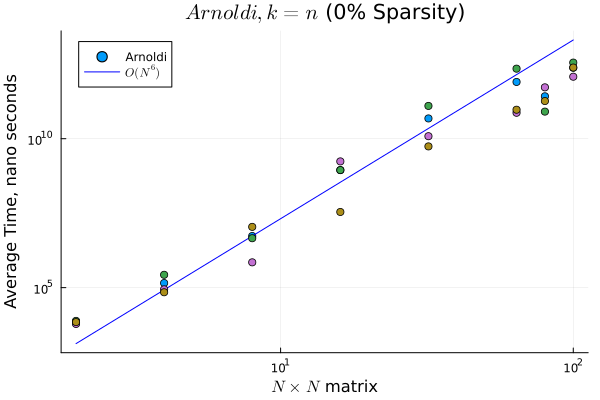

In [7]:
msize=[2,4,8,16,32,64,80,100]
times1=[7670.0, 270370.0, 4.56498e6, 8.845209e8, 1.262998136e11, 2.2494530575e12, 8.13452993e10, 3.5966422346e12]
times2=[6050.0, 87920.0, 708620.0, 1.73361585e9, 1.21490856e10, 7.44053277e10, 5.313302287e11, 1.2074416092e12]
times3=[6990.0, 70070.0, 1.097951e7, 3.474861e7, 5.5271172e9, 9.40631805e10, 1.84159339e11, 2.4507259399e12]
avgtimes=(times1.+times2.+times3)/3

plot(msize,avgtimes,xaxis=:log10,yaxis=:log10,seriestype=:scatter,label="Arnoldi")
complexity =@. avgtimes[3]*msize^6/msize[3]^6
plot!(msize,complexity,linecolor=:blue,label=L"O(N^6)")
plot!(msize,times1, seriestype=:scatter,label="")
plot!(msize,times2, seriestype=:scatter,label="")
plot!(msize,times3, seriestype=:scatter,label="")
xlabel!(L"$N\times N$ matrix")
ylabel!("Average Time, nano seconds")
title!(L"$Arnoldi, k=n$ (0% Sparsity)")
plot!(legend=:topleft)